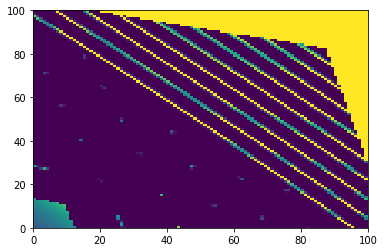

In [180]:
# This notebook will be the auto-tuning routine that will find a single 
# dot window using the subimage classifier

import matplotlib.pyplot as plt
%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)

import numpy as np
import tensorflow as tf
import glob
import os
import time

from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

# application logic will be added here
def cnn_model_fn(features,labels,mode):
    '''Model function for CNN'''
    #input layer
    input_layer = tf.cast(tf.reshape(features,[-1,30,30,1]),tf.float32)
    
    conv1 = tf.layers.conv2d(inputs=input_layer,
                            filters=32,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2],strides=2)
    
    conv2 = tf.layers.conv2d(inputs=pool1,
                            filters=64,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],strides=2)
    
    flat = tf.contrib.layers.flatten(inputs=pool2)
    # dense output layer
    out1 = tf.layers.dense(inputs=flat,units=1024,activation=tf.nn.relu)  
    dropout1 = tf.layers.dropout(
      inputs=out1, rate=0.4, training=mode == learn.ModeKeys.TRAIN)
    
    out = tf.layers.dense(inputs=dropout1, units=4)
    
    loss = None
    train_op = None

    # Calculate loss( for both TRAIN AND EVAL modes)
    if mode != learn.ModeKeys.INFER:
        loss = tf.losses.mean_squared_error(out,labels['prob'])

    # Configure the training op (for TRAIN mode)
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=tf.contrib.framework.get_global_step(),
            learning_rate=1e-3,
            optimizer=tf.train.AdamOptimizer)

    # Generate predictions
    predictions= {
        "prob" : out,
        "states" : tf.argmax(out,axis=1),
    }
    
    # Returna  ModelFnOps object
    return model_fn_lib.ModelFnOps(mode=mode,predictions=predictions,loss=loss, train_op=train_op)
dd_classifier = learn.Estimator(model_fn=cnn_model_fn,model_dir="/tmp/cnn_prob/")


def fitness(param,sub_size,dat,classifier):
    x = int(param[0])
    y = int(param[1])
    sub_image = dat[(x - int(sub_size/2)) :\
                (x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))].flatten()
    state = classifier.predict(x=np.array([sub_image],dtype=np.float32),as_iterable=False)
    fitness = np.linalg.norm(state['prob'] - np.array([0,0,1,0]))
    return fitness

x_0 = 25
y_0 = 25
sub_size = 30
data_folder_path = "/Users/ssk4/Downloads/dataproc/"
files = glob.glob(data_folder_path + "*.npy")
index = np.random.randint(len(files))
dat = np.load(files[index]).item()['current_map']
plt.pcolor(dat,vmax=1e-2)

x_vec = np.arange(15,85,5)
y_vec = np.arange(15,85,5)
xx,yy = np.meshgrid(x_vec,y_vec)
fit = np.zeros((len(x_vec),len(x_vec)))
#for i in range(len(x_vec)):
#    print(i)
#    for j in range(len(y_vec)):
#        x_0 = xx[i,j]
#        y_0 = yy[i,j]
#        fit[i,j] = fitness((x_0,y_0),sub_size,dat,dd_classifier)
#print(fit)



Initial fitness 1.29396168108
     fun: 0.0053220488367122822
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 25
  status: 1
 success: True
       x: array([ 68.1419403 ,  62.56994487])


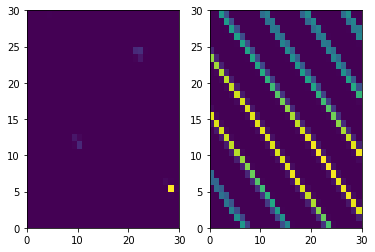

In [182]:

def fitness(param,sub_size,dat,classifier):
    x = int(param[0])
    y = int(param[1])
    sub_image = dat[(x - int(sub_size/2)) :\
                (x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))].flatten()
    state = classifier.predict(x=np.array([sub_image],dtype=np.float32),as_iterable=False)
    fitness = np.linalg.norm(state['prob'] - np.array([0,0,1,0]))
    return fitness


import scipy.optimize
x_0 = 25
y_0 = 25
start_sub_image = dat[(x_0 - int(sub_size/2)) :\
                (x_0 + int(sub_size/2)),(y_0 - int(sub_size/2)):(y_0+int(sub_size/2))]
print("Initial fitness",fitness((x_0,y_0),sub_size,dat,dd_classifier))
guess = np.array([x_0,y_0])
cons = [{"type":"ineq","fun":lambda x: x[0] - 16},
        {"type":"ineq","fun":lambda x: x[1] - 16},
        {"type":"ineq","fun":lambda x: 84 - x[0]},
        {"type":"ineq","fun":lambda x: 84 - x[1]}]

res = scipy.optimize.minimize(fitness,x0=guess,args=(sub_size,dat,dd_classifier),method="cobyla",
                              options={"rhobeg":30.0,"disp":True},constraints=cons)
print(res)
x = int(res.x[0])
y = int(res.x[1])
sub_image = dat[(x - int(sub_size/2)) :\
                (x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))]
plt.subplot(1,2,1)
plt.pcolor(start_sub_image)
plt.subplot(1,2,2)
plt.pcolor(sub_image)

basinhopping step 0: f 1.29451
basinhopping step 1: f 1.29213 trial_f 1.29213 accepted 1  lowest_f 1.29213
found new global minimum on step 1 with function value 1.29213
basinhopping step 2: f 1.24172 trial_f 1.24172 accepted 1  lowest_f 1.24172
found new global minimum on step 2 with function value 1.24172
basinhopping step 3: f 1.20774 trial_f 1.20774 accepted 1  lowest_f 1.20774
found new global minimum on step 3 with function value 1.20774
basinhopping step 4: f 1.20774 trial_f 1.22207 accepted 0  lowest_f 1.20774
basinhopping step 5: f 1.20606 trial_f 1.20606 accepted 1  lowest_f 1.20606
found new global minimum on step 5 with function value 1.20606
basinhopping step 6: f 1.20535 trial_f 1.20535 accepted 1  lowest_f 1.20535
found new global minimum on step 6 with function value 1.20535
basinhopping step 7: f 1.20535 trial_f 1.2103 accepted 0  lowest_f 1.20535
basinhopping step 8: f 1.20213 trial_f 1.20213 accepted 1  lowest_f 1.20213
found new global minimum on step 8 with functio

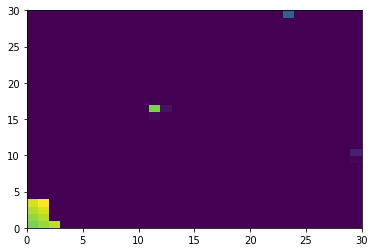

In [155]:
import scipy.optimize
x_0 = 25
y_0 = 25
guess = np.array([x_0,y_0])
res = scipy.optimize.basinhopping(fitness,x0=guess,minimizer_kwargs={"args":(sub_size,dat,dd_classifier)}
                                 ,stepsize=5.0,T=1e-3,niter=25,disp=True)
print(res)
x = int(res.x[0])
y = int(res.x[0])
sub_image = dat[(x - int(sub_size/2)) :\
                (x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))]
plt.pcolor(sub_image)

In [144]:
res.x[0]

55.924734758291116

In [80]:
xx[0,69]

84

In [86]:
x_0 = 15
y_0 = 84
fitness((x_0,y_0),sub_size,dat,dd_classifier)

0.32660072586036004

In [84]:
dat.shape

(100, 100)

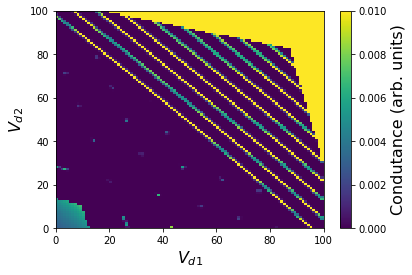

In [189]:
plt.pcolor(dat,vmax=1e-2)
plt.xlabel(r'$V_{d1}$',fontsize=16)
plt.ylabel(r'$V_{d2}$',fontsize=16)
cb = plt.colorbar()
cb.set_label('Condutance (arb. units)',fontsize=16)